In [1]:

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")


In [2]:

df = pd.read_csv("electrode_data.csv")
df.head()


,Pos_D,Neg_D,Pos_var,Neg_var,Capacity,Stability
0,-10.29423,-10.30980,0.36592,0.27136,224.2,0.75
1,-10.29423,-10.88714,0.36592,0.22075,265.4,0.82
2,-10.29423,-11.26269,0.36592,0.65550,18.4,0.55
3,-10.29423,-10.43430,0.36592,0.25055,65.6,0.70
4,-10.29423,-11.29965,0.36592,0.60348,68.5,0.31


In [3]:

X = df[['Pos_D', 'Neg_D', 'Pos_var', 'Neg_var']].copy()
X['D_ratio'] = df['Pos_D'] / df['Neg_D']
X['var_sum'] = df['Pos_var'] + df['Neg_var']
X['overlap_index'] = np.minimum(df['Pos_D'], df['Neg_D']) / np.maximum(df['Pos_D'], df['Neg_D'])

mu_pos = df['Pos_D']
mu_neg = df['Neg_D']
sigma_pos = np.sqrt(df['Pos_var'].clip(lower=0))
sigma_neg = np.sqrt(df['Neg_var'].clip(lower=0))

X['CSI'] = (np.abs(mu_pos - mu_neg) + 2 * np.abs(sigma_pos - sigma_neg)) / (sigma_pos + sigma_neg)
X['WDD'] = (mu_pos * sigma_pos - mu_neg * sigma_neg) / (mu_pos + mu_neg)
#X['NDM'] = np.abs(mu_pos - mu_neg) / (mu_pos + mu_neg)
X['AI'] = (sigma_pos - sigma_neg) / (sigma_pos + sigma_neg)
#X['Span'] = np.abs(np.log10(mu_pos / mu_neg).clip(lower=1e-20))
#X['EMF'] = 1 - X['CSI']
#X['log_D_ratio'] = np.log10(X['D_ratio'].clip(lower=1e-20))
#X['D_ratio_squared'] = X['D_ratio'] ** 2
X['D_ratio_CSI'] = X['D_ratio'] * X['CSI']
#X['D_ratio_EMF'] = X['D_ratio'] * X['EMF']
#X['D_ratio_overlap'] = X['D_ratio'] * X['overlap_index']


y = df['Stability']


In [4]:

X = X.dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



XGBoost R²: 0.8856146494900283
RMSE: 0.06718225427054851


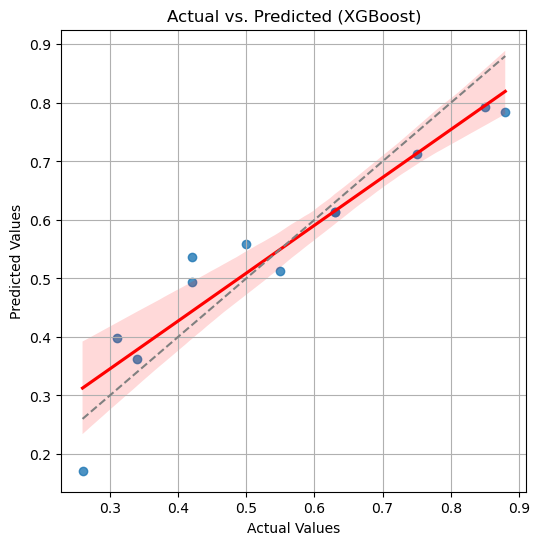

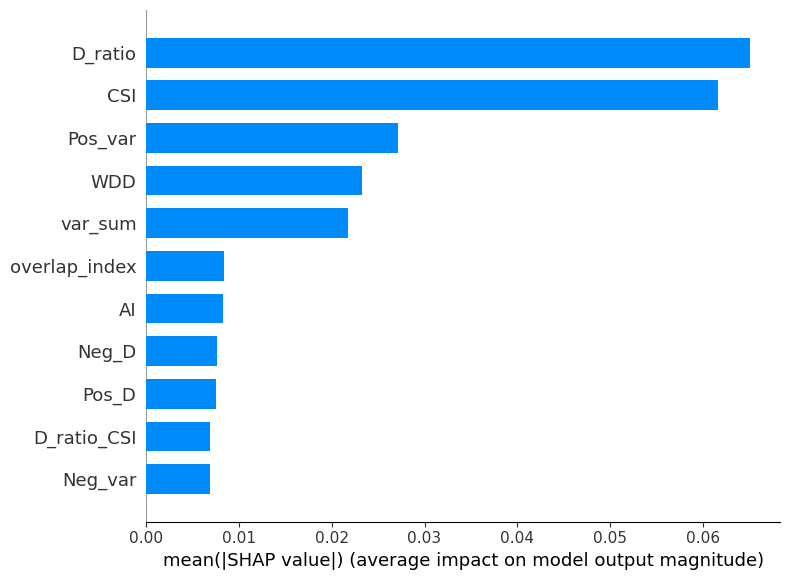

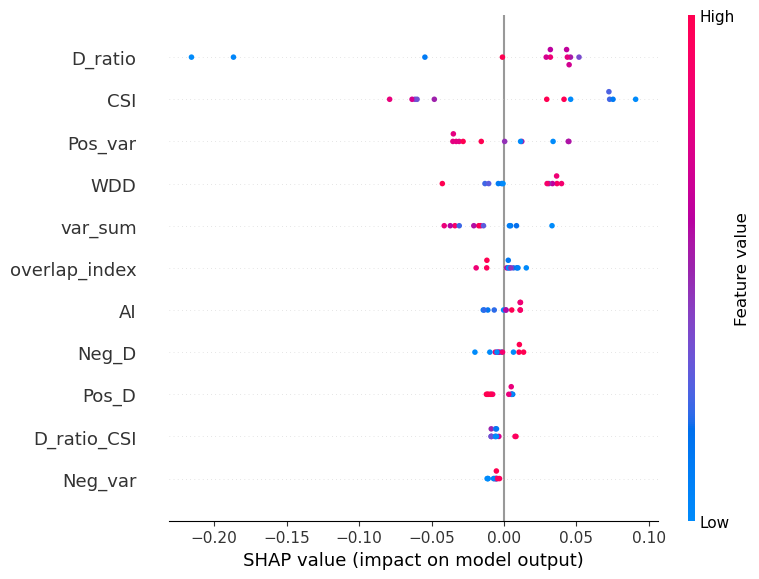

In [5]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost R²:", r2_score(y_test, xgb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))

plt.figure(figsize=(6,6))
sns.regplot(x=y_test, y=xgb_preds, line_kws={'color':'red'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (XGBoost)")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.savefig("actual_vs_predicted.jpg", dpi=300)  # ← 保存为 JPG，300 dpi 清晰
plt.show()

explainer_xgb = shap.Explainer(xgb, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test)

# 第一个图：bar
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.savefig("shap_summary_bar.jpg", dpi=300, bbox_inches='tight')
plt.close()

# 第二个图：dot
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.savefig("shap_summary_dot.jpg", dpi=300, bbox_inches='tight')
plt.close()

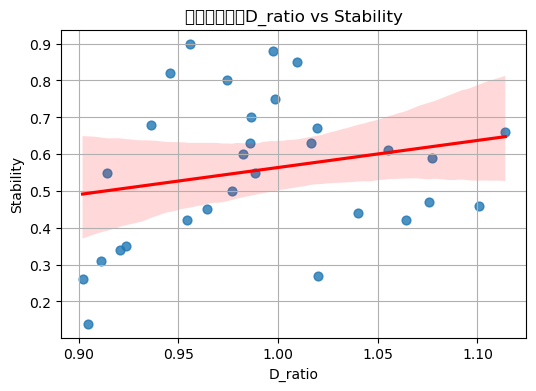

In [6]:
plt.figure(figsize=(6,4))
sns.regplot(x=X['D_ratio'], y=y, scatter_kws={'s':40}, line_kws={'color':'red'})
plt.xlabel("D_ratio")
plt.ylabel("Stability")
plt.title("实际值关系：D_ratio vs Stability")
plt.grid(True)
plt.show()


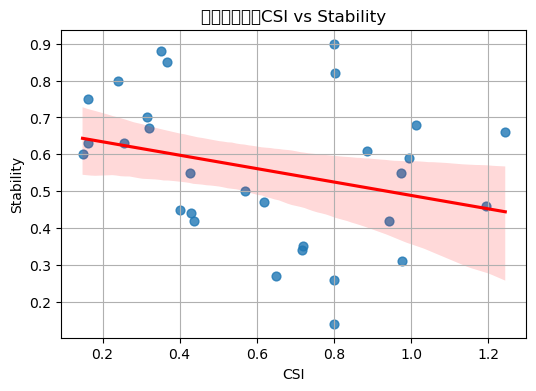

In [7]:
plt.figure(figsize=(6,4))
sns.regplot(x=X['CSI'], y=y, scatter_kws={'s':40}, line_kws={'color':'red'})
plt.xlabel("CSI")
plt.ylabel("Stability")
plt.title("实际值关系：CSI vs Stability")
plt.grid(True)
plt.show()


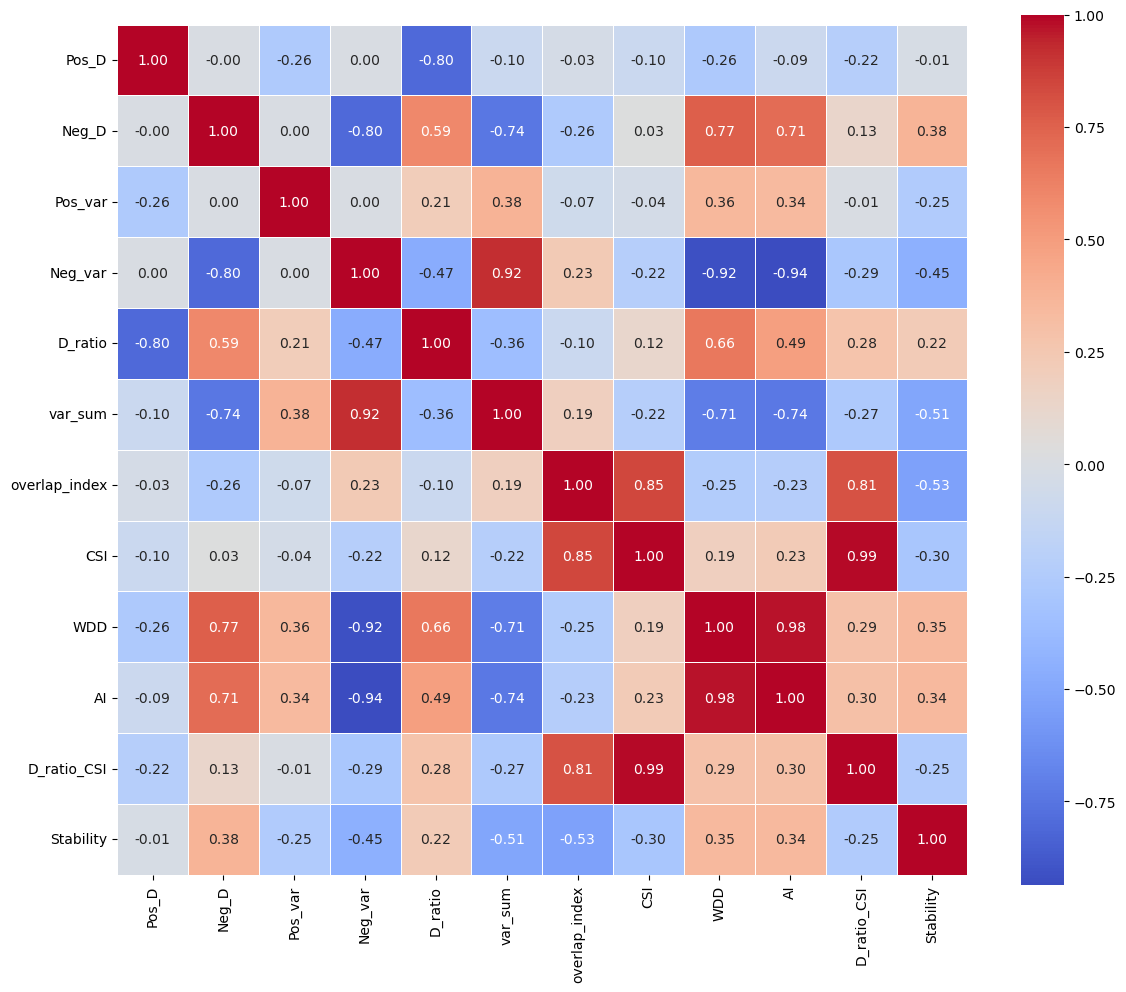

In [8]:
plt.figure(figsize=(12, 10))

# 合并特征和目标变量，计算相关性
corr_matrix = X.copy()
corr_matrix['Stability'] = y
corr = corr_matrix.corr()

# 绘制热力图
sns.heatmap(corr, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=0.5, 
            fmt=".2f", 
            square=True, 
            cbar=True)

#plt.title("特征与 Stability 的相关性矩阵热力图（含自相关）")
plt.tight_layout()
plt.savefig("related.jpg", dpi=300)  # ← 保存为 JPG，300 dpi 清晰
plt.show()


In [9]:
# 用训练集预测 y 值，避免数据太少
train_preds = xgb.predict(X_train)

# 将预测值与对应特征组合为 DataFrame
df_pred = X_train.copy()
df_pred['Predicted_Stability'] = train_preds

# 找到预测值较高的前30%（高性能区域）
threshold = np.percentile(train_preds, 70)
high_perf = df_pred[df_pred['Predicted_Stability'] >= threshold]

# 输出 D_ratio 和 CSI 在这个区域的分布范围
d_min, d_max = high_perf['D_ratio'].min(), high_perf['D_ratio'].max()
c_min, c_max = high_perf['CSI'].min(), high_perf['CSI'].max()

print("✅ 为获得较高 Stability（预测值前30%）：")
print(f" - D_ratio 推荐范围：{d_min:.3f} ~ {d_max:.3f}")
print(f" - CSI 推荐范围：{c_min:.3f} ~ {c_max:.3f}")


✅ 为获得较高 Stability（预测值前30%）：
 - D_ratio 推荐范围：0.936 ~ 1.020
 - CSI 推荐范围：0.241 ~ 1.013


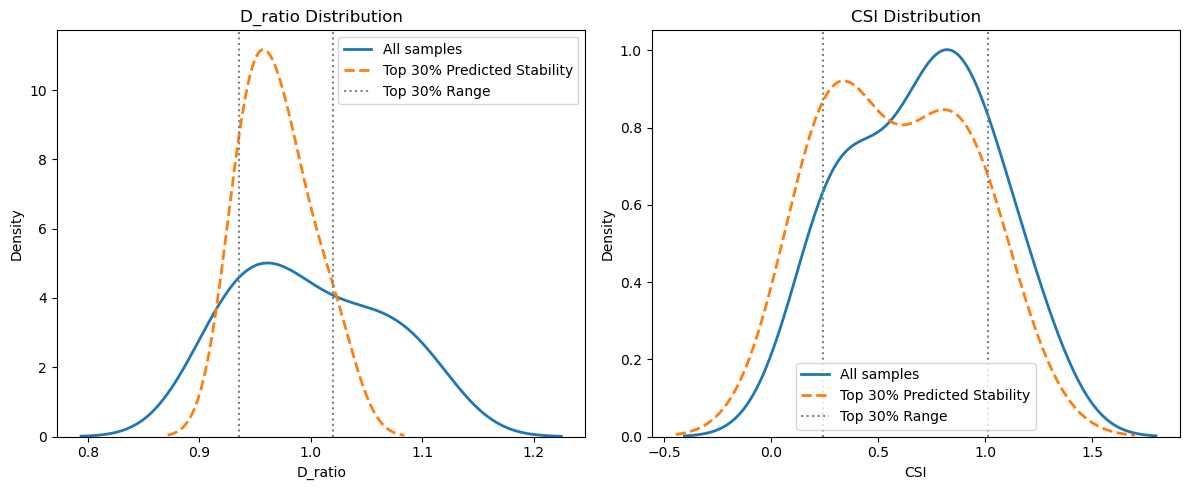

In [10]:
# 可视化 D_ratio 和 CSI 在高性能区域的分布
plt.figure(figsize=(12, 5))

# D_ratio 分布图
plt.subplot(1, 2, 1)
sns.kdeplot(X_train['D_ratio'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['D_ratio'], label='Top 30% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(d_min, color='gray', linestyle=':', label='Top 30% Range')
plt.axvline(d_max, color='gray', linestyle=':')
plt.xlabel("D_ratio")
plt.title("D_ratio Distribution")
plt.legend()

# CSI 分布图
plt.subplot(1, 2, 2)
sns.kdeplot(X_train['CSI'], label='All samples', linewidth=2)
sns.kdeplot(high_perf['CSI'], label='Top 30% Predicted Stability', linewidth=2, linestyle='--')
plt.axvline(c_min, color='gray', linestyle=':', label='Top 30% Range')
plt.axvline(c_max, color='gray', linestyle=':')
plt.xlabel("CSI")
plt.title("CSI Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("D_CSI_high_stability_distribution.jpg", dpi=300)
plt.show()
